# Depression Detection in Social Media Posts

#### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


#### Constants

In [2]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

## Section 1: Load Data

Loading depressive tweets scraped from twitter using [TWINT](https://github.com/haccer/twint) and random tweets from Kaggle dataset [twitter_sentiment](https://www.kaggle.com/ywang311/twitter-sentiment/data).

#### File Paths

In [3]:
#DEPRESSIVE_TWEETS_CSV = 'depressive_tweets.csv'
DEPRESSIVE_TWEETS_CSV = 'depressive_tweets.csv'
RANDOM_TWEETS_CSV = 'random_tweets.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [4]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = ',', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV,sep=',',header = None , usecols = range(0,9), nrows = RANDOM_NROWS)

In [5]:
depressive_tweets_df

,0,1,2,3,4,5,6,7,8
0,1.045021e+18,2018-09-27,00:12:11,India Standard Time,1.430323e+07,15dozentimes,It's always kind of weird when the depression ...,1,0
1,1.045021e+18,2018-09-27,00:12:06,India Standard Time,7.655485e+17,taIizzle,i was severely depressed during the summer of ...,0,0
2,1.045021e+18,2018-09-27,00:12:02,India Standard Time,1.043997e+18,DragonQueenHalo,What it's like to be me: I wake up in a panic ...,0,0
3,1.045021e+18,2018-09-27,00:12:00,India Standard Time,4.027673e+08,jnnfrsbdy,"@aquariusguts bpd, anxiety and depression 👻",0,0
4,1.045021e+18,2018-09-27,00:11:48,India Standard Time,8.204317e+17,MeganeMea,Depression makes you forget you were trying to...,0,0
5,1.045021e+18,2018-09-27,00:11:48,India Standard Time,2.677009e+08,heartCHANGMIN,can we really survive depression???? https://...,0,0
6,1.045021e+18,2018-09-27,00:11:37,India Standard Time,1.794834e+07,lesliekelly,@shilohwalker Much love to you and your family...,0,0
7,1.045021e+18,2018-09-27,00:11:37,India Standard Time,2.989073e+09,laursergui,CUTTING MY HAIR WONT CURE MY DEPRESSION,0,0
8,1.045021e+18,2018-09-27,00:11:31,India Standard Time,1.034209e+18,caitmev,@HereForTheTea2 I knew that she felt bullied. ...,0,0
9,1.045021e+18,2018-09-27,00:11:29,India Standard Time,2.490582e+09,_flexinnnn,Not all mental health is depression jack ass ...,0,0


In [6]:
random_tweets_df

,0,1,2,3,4,5,6,7,8
0,1.040752e+18,2018-09-15,05:29:59,India Standard Time,8.580064e+17,CaiyaJae,@tori_schleicher I’m weak 😂,1,0
1,1.040752e+18,2018-09-15,05:29:59,India Standard Time,4.177066e+09,RyanL1872,"Watch out @DundeeFC YT, @Burns1872 is ready 🇬🇧...",0,2
2,1.040752e+18,2018-09-15,05:29:59,India Standard Time,2.557082e+09,SirLitness,Me vs the world.,1,0
3,1.040752e+18,2018-09-15,05:29:59,India Standard Time,2.281425e+08,oneofthe5daves,@Twitter I heard everyone knows at least 5 Dav...,0,0
4,1.040752e+18,2018-09-15,05:29:59,India Standard Time,2.858842e+08,ThatWeissGuy,"Paranoia about the ""death of print"" has become...",1,2
5,1.040752e+18,2018-09-15,05:29:59,India Standard Time,1.037502e+18,QUEENbAE408,"@ChrisV1988 Haha babe, it supposed to look lik...",0,0
6,1.040752e+18,2018-09-15,05:29:59,India Standard Time,1.923669e+08,shannapope,@simplyn2deep I was fortunate enough to have a...,1,0
7,1.040752e+18,2018-09-15,05:29:59,India Standard Time,3.311392e+09,creditbook68,@AdamRubinMedia Such a shame those 2 never got...,0,0
8,1.040752e+18,2018-09-15,05:29:59,India Standard Time,4.776908e+09,moonIightwitch,@technoviscera you’re so..... Thank You,0,0
9,1.040752e+18,2018-09-15,05:29:59,India Standard Time,2.536611e+07,writerslink,Stormy Daniels to Publish a Tell-All Book Abou...,0,0


## Section 2: Data Processing

### Load Pretrained Word2Vec Model

The pretrained vectors for the Word2Vec model is from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).
Using a Keyed Vectors file, we can get the embedding of any word by calling `.word_vec(word)` and we can get all the words in the model's vocabulary through `.vocab`.

In [7]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

### Preprocessing

Preprocessing the tweets in order to:
* Remove links and images
* Remove hashtags
* Remove @ mentions
* Remove emojis
* Remove stop words
* Remove punctuation
* Get rid of stuff like "what's" and making it "what is'
* Stem words so they are all the same tense (e.g. ran -> run)

In [8]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [9]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

Applying the preprocessing `clean_text` function to every element in the depressive tweets and random tweets data.

In [10]:
depressive_tweets_arr = [x for x in depressive_tweets_df[6]]
random_tweets_arr = [x for x in random_tweets_df[6]]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

### Tokenizer

Using a Tokenizer to assign indices and filtering out unfrequent words. Tokenizer creates a map of every unique word and an assigned index to it. The parameter called num_words indicates that we only care about the top 20000 most frequent words.

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

Applying the tokenizer to depressive tweets and random tweets data.

In [12]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

Number of unique words in tokenizer. Has to be <= 20,000.

In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 29345 unique tokens


Pad sequences all to the same length of 140 words.

In [14]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (3197, 140)
Shape of data_r tensor: (11923, 140)


### Embedding Matrix

The embedding matrix is a `n x m` matrix where `n` is the number of words and `m` is the dimension of the embedding. In this case, `m=300` and `n=20000`. We take the min between the number of unique words in our tokenizer and max words in case there are less unique words than the max we specified.

In [15]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

### Splitting and Formatting Data

Assigning labels to the depressive tweets and random tweets data, and splitting the arrays into test (60%), validation (20%), and train data (20%). Combine depressive tweets and random tweets arrays and shuffle.

In [16]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## Section 3: Building the Model

### Building Model (LSTM + CNN)

The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with it's embeddings, then run the new embedding vector through a convolutional layer. CNNs are excellent at learning spatial structure from data, the convolutional layer takes advantage of that and learn some structure from the sequential data then pass into a standard LSTM layer. Last but not least, the output of the LSTM layer is fed into a standard Dense model for prediction.

In [17]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### Compiling Model

In [18]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total para

## Section 4: Training the Model

The model is trained `EPOCHS` time, and Early Stopping argument is used to end training if the loss or accuracy don't improve within 3 epochs.

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Train on 9071 samples, validate on 3025 samples
Epoch 1/10
9071/9071 [==============================] - 47s 5ms/step - loss: 0.1508 - acc: 0.9525 - val_loss: 0.0833 - val_acc: 0.9828
Epoch 2/10
9071/9071 [==============================] - 35s 4ms/step - loss: 0.0664 - acc: 0.9838 - val_loss: 0.0708 - val_acc: 0.9815
Epoch 3/10
9071/9071 [==============================] - 35s 4ms/step - loss: 0.0522 - acc: 0.9870 - val_loss: 0.0731 - val_acc: 0.9835
Epoch 4/10
9071/9071 [==============================] - 36s 4ms/step - loss: 0.0443 - acc: 0.9885 - val_loss: 0.0775 - val_acc: 0.9825
Epoch 5/10
9071/9071 [==============================] - 36s 4ms/step - loss: 0.0363 - acc: 0.9896 - val_loss: 0.0844 - val_acc: 0.9825


### Results

Summarize history for accuracy

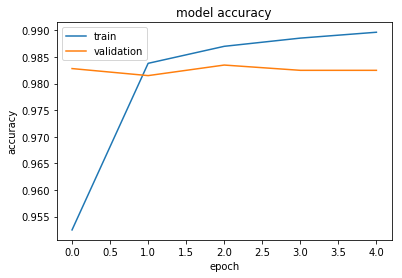

In [20]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Summarize history for loss

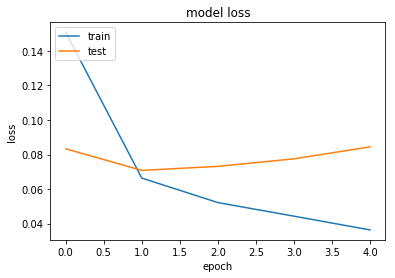

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Percentage accuracy of model

In [22]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.48%


f1, precision, and recall scores

In [23]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2385
           1       0.98      0.95      0.96       639

   micro avg       0.98      0.98      0.98      3024
   macro avg       0.98      0.97      0.98      3024
weighted avg       0.98      0.98      0.98      3024

